# Simple Stock Price Prediction Model

Created by Marc Zeugin

### Import modules

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import math
import os

### Set tickers

In [2]:
tickers = ['AAL', 'AAPL', 'AAP', 'MSFT']

### Set options

In [3]:
period = '5y'
training_data_split = 0.8

### Load financial data from yahoo finance API or local folder if available

In [4]:
ticker_hist_list = []

for ticker in tickers:
    path = './data/' + ticker + '_data.json'
    if os.path.exists(path=path):
        with open(path) as f:
            temp_ticker_hist = pd.read_json(path)
        ticker_hist_list.append(temp_ticker_hist)
    else:
        temp_ticker = yf.Ticker(ticker=ticker)
        temp_ticker_hist = temp_ticker.history(period=period)
        ticker_hist_list.append(temp_ticker_hist)

### Save data to local folder

In [5]:
for i in range(len(ticker_hist_list)):
    ticker_hist_list[i].to_json('./data/' + tickers[i] + '_data.json')

### Display some data properties

In [6]:
for i in range(len(ticker_hist_list)):
    # print(ticker_hist_list[i].head(5))
    print(ticker_hist_list[i].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-06-05 to 2022-06-02
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Dividends     1259 non-null   float64
 6   Stock Splits  1259 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 111.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-06-05 to 2022-06-02
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Volume        1259 non-null   int64  
 5   Di

### Display all stocks plots

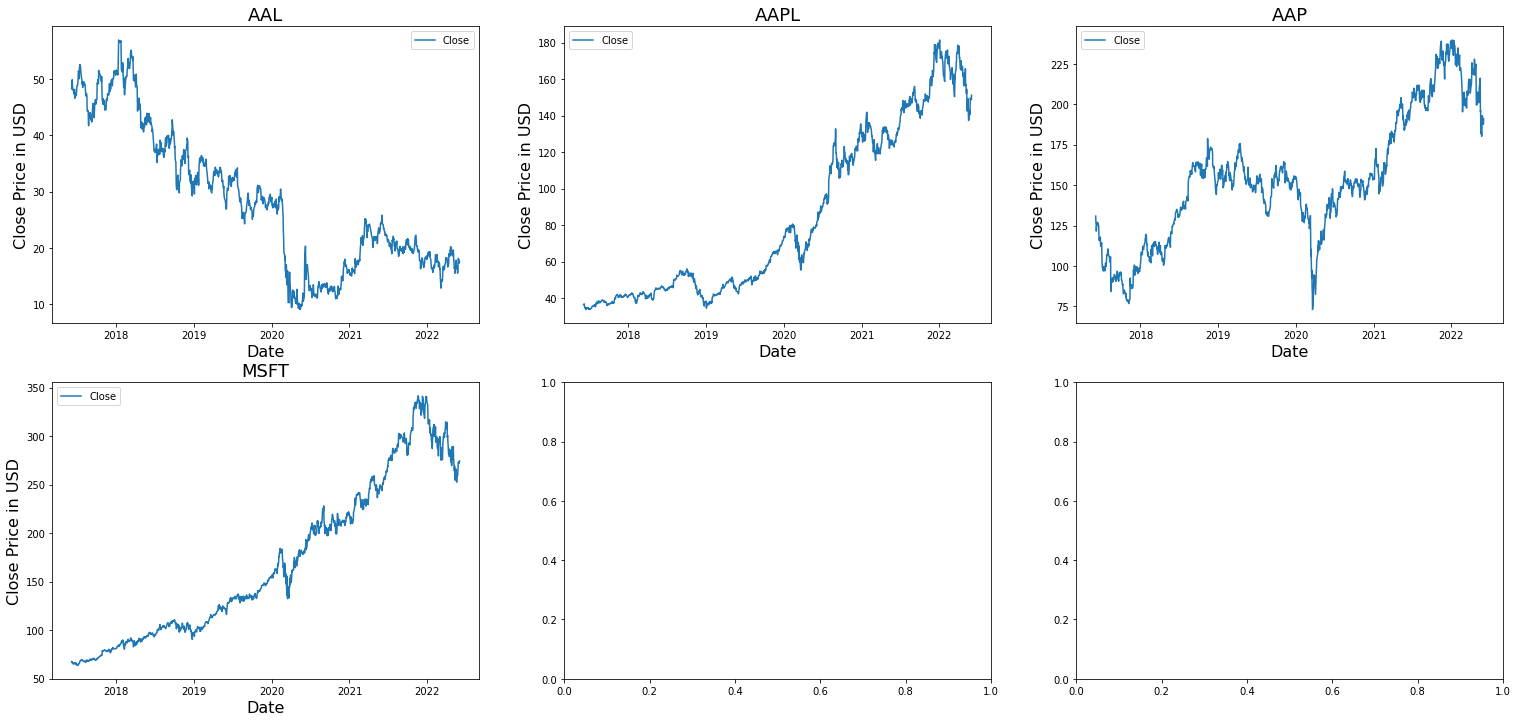

In [7]:
rows = int(math.ceil(len(tickers)/3))
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(26, 6*rows))

if rows == 1:
    for col in range(cols):
        ax[col].set_title(tickers[col], fontsize=18)
        ax[col].plot(ticker_hist_list[col]['Close'], label='Close')
        ax[col].legend(loc='best')
        ax[col].set_xlabel('Date', fontsize=16)
        ax[col].set_ylabel('Close Price in USD', fontsize=16)
else:
    for row in range(rows):
        for col in range(cols):
            if col + 3*row < len(tickers):
                ax[row, col].set_title(tickers[col + 3*row], fontsize=18)
                ax[row, col].plot(ticker_hist_list[col + 3*row]['Close'], label='Close')
                ax[row, col].legend(loc='best')
                ax[row, col].set_xlabel('Date', fontsize=16)
                ax[row, col].set_ylabel('Close Price in USD', fontsize=16)
plt.show()

### Apply MinMaxScaler to dataset

In [8]:
close_data = ticker_hist_list[2].filter(['Close'])
dataset = close_data.values
training_data_len = math.ceil(len(ticker_hist_list[2])*training_data_split)

scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

print(scaled_dataset.shape)

(1259, 1)


### Split into training and testing data & reshape input for LSTM model to match requirements

In [9]:
step = 60

#Creating the scaled training data set
train_data = scaled_dataset[0:training_data_len, : ]
#Spliting the data into x_train and y_train data sets
X_train = []
y_train = []
for i in range(step, len(train_data)):
    X_train.append(train_data[i-step:i, 0])
    y_train.append(train_data[i, 0])
    
#Here we are Converting x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Here we are reshaping the data into the shape accepted by the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# here we are testing data set
test_data = scaled_dataset[training_data_len-step: , : ]
#Creating the X_test and y_test data sets
X_test = []
y_test =  dataset[training_data_len: , : ]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    
# here we are converting x_test to a numpy array  
X_test = np.array(X_test)

# here we are reshaping the data into the shape accepted by the LSTM  
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Setup the LSTM model

In [10]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, input_shape=(step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(16))
model.add(Dense(1, activation='linear'))
model.compile(loss="mean_squared_error" , optimizer="adam")

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 60, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 16)            2112      
                                                                 
 dropout_1 (Dropout)         (None, 60, 16)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 1

### Fit LSTM model

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
15/15 [==============================] - 5s 106ms/step - loss: 0.0756 - val_loss: 45455.1719
Epoch 2/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0171 - val_loss: 45543.0000
Epoch 3/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0107 - val_loss: 45486.9180
Epoch 4/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0079 - val_loss: 45490.7969
Epoch 5/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0058 - val_loss: 45461.2266
Epoch 6/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0042 - val_loss: 45429.7383
Epoch 7/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0039 - val_loss: 45417.9453
Epoch 8/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0036 - val_loss: 45423.6836
Epoch 9/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0034 - val_loss: 45421.2812
Epoch 10/100
15/15 [==============================] - 1s 38ms/s

dict_keys(['loss', 'val_loss'])


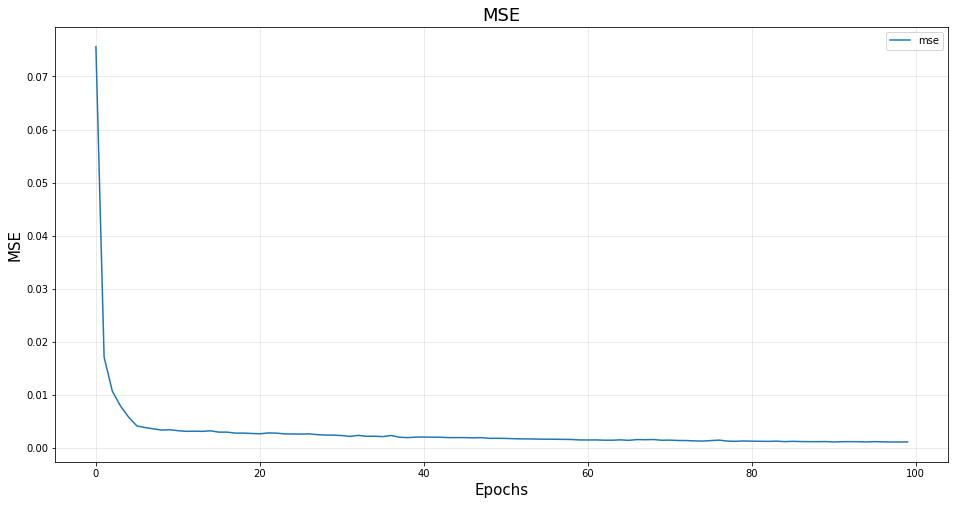

In [18]:
print(history.history.keys())
plt.figure(figsize=(16, 8))

# Accuracy
plt.plot(history.epoch, history.history['loss'], label = "mse")

plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### Create predictions

In [25]:
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

8/8 [==============================] - 0s 14ms/step


### Calculate RMSE and MAE

In [26]:
print(math.sqrt(mean_squared_error(y_test, test_predict)))
print(mean_absolute_error(y_test, test_predict))

8.082605423850845
6.614336720503162


### Plot prediction vs actual close price

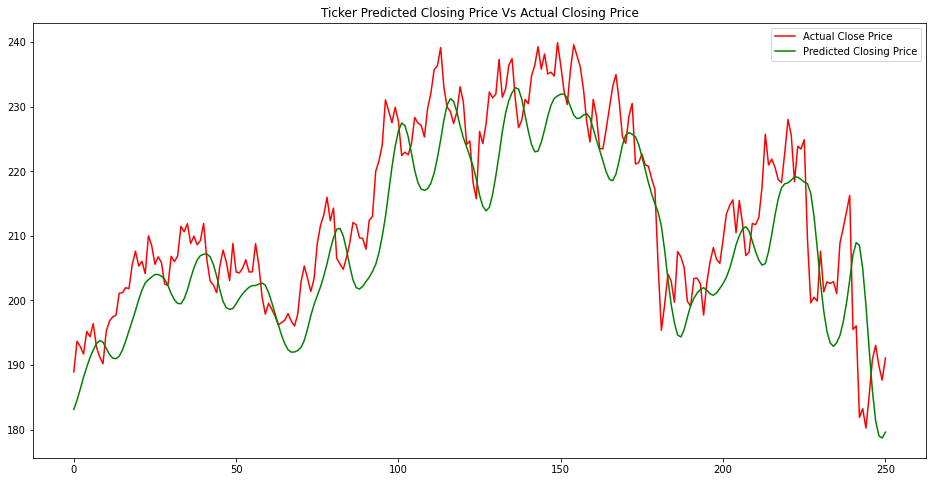

In [29]:
plt.figure(figsize=(16, 8))
plt.title('Ticker Predicted Closing Price Vs Actual Closing Price')
plt.plot(y_test, color='red', label='Actual Close Price')
plt.plot(test_predict, color='green', label='Predicted Closing Price')
plt.legend(loc='best')
plt.show()